In [4]:
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os
from astropy.io import fits
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
source_name='NGC 2110'
ra=88.047400
dec=-7.456247
radius=10.
Tstart='2003-03-15T00:00:00'
Tstop='2018-03-15T00:00:00'
E1_keV=30.
E2_keV=100.
host='www.astro.unige.ch/cdci/astrooda/dispatch-data'
rebin=10 # minimal significance in energy bin, for spectral plotting

In [6]:
try: input = raw_input
except NameError: pass
token=input() # token for restricted access server
cookies=dict(_oauth2_proxy=token)
disp=DispatcherAPI(host=host)

In [7]:
disp=DispatcherAPI(host=host)

In [8]:
import requests
url="https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/"
def queryxtime(**args):
    params=Tstart+'/'+Tstop+'?&ra='+str(ra)+'&dec='+str(dec)+'&radius='+str(radius)+'&min_good_isgri=1000'
    print(url+params)
    return requests.get(url+params,cookies=cookies).json()

In [9]:
#if token!='':
scwlist=queryxtime()
m=len(scwlist)
pointings_osa10=[]
pointings_osa11=[]
for i in range(m):
    if scwlist[i][-2:]=='10':
        if(int(scwlist[i][:4])<1626):
            pointings_osa10.append(scwlist[i]+'.001')
        else:
            pointings_osa11.append(scwlist[i]+'.001')
#else:
#    pointings=np.genfromtxt('scws_3C279_isgri_10deg.txt', dtype='str')
m_osa10=len(pointings_osa10)
m_osa11=len(pointings_osa11)

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/2003-03-15T00:00:00/2018-03-15T00:00:00?&ra=88.0474&dec=-7.456247&radius=10.0&min_good_isgri=1000


In [10]:
def chunk_swc_list(lst, size):
    _l = [lst[x:x+size] for x in range(0, len (lst), size)]
    for ID,_ in enumerate(_l):
        _l[ID]=','.join(_)
       
    return _l

In [11]:
scw_lists_osa10=chunk_swc_list(pointings_osa10, 50)
scw_lists_osa11=chunk_swc_list(pointings_osa11, 50)

In [12]:
data=disp.get_product(instrument='isgri',
                      product='isgri_image',
                      scw_list=scw_lists_osa10[0],
                      E1_keV=E1_keV,
                      E2_keV=E2_keV,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=3.5,
                      product_type='Real')

048300050010.001,048300060010.001,048300070010.001,048300080010.001,048300160010.001,048300370010.001,048700080010.001,048700090010.001,048700100010.001,048700170010.001,048700180010.001,048700190010.001,048700580010.001,048700590010.001,048700600010.001,053000540010.001,053000550010.001,053000560010.001,053000630010.001,053000640010.001,053000660010.001,053200050010.001,053200060010.001,053200150010.001,053200360010.001,053200440010.001,053200450010.001,053200460010.001,053200470010.001,053200540010.001,053200550010.001,053200560010.001,053800040010.001,053800250010.001,053800330010.001,053800340010.001,053800350010.001,053800360010.001,053800430010.001,053800440010.001,053800450010.001,053800460010.001,053800540010.001,054300260010.001,054300340010.001,054300350010.001,054300360010.001,054300370010.001,054300430010.001,054300440010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 048300050010.001,048300060010.

In [13]:
data.dispatcher_catalog_1.table



meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str10,float64,float64,float64,int64,int64,int64,float64
3,Ark 120,4.453483581542969,79.04783630371094,-0.15016700327396393,-32768,2,0,0.0002800000074785203
4,H 0614+091,12.6614990234375,94.28777313232422,9.13561725616455,-32768,2,0,0.0002800000074785203
14,NGC 2110,14.64085865020752,88.04682922363281,-7.458226203918457,-32768,2,0,0.0002800000074785203


In [14]:
FLAG=0
torm=[]
for ID,n in enumerate(data.dispatcher_catalog_1.table['src_names']):
    if(n=='NEW_1'):
        torm.append(ID)
    if(n==source_name):
        FLAG=1
data.dispatcher_catalog_1.table.remove_rows(torm)

nrows=len(data.dispatcher_catalog_1.table['src_names'])
print(nrows)
print(FLAG)

3
1


In [15]:
if FLAG==0:
    data.dispatcher_catalog_1.table.add_row((0,'3C 279',0,ra,dec,0,2,0,0))
    
data.dispatcher_catalog_1.table    

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str10,float64,float64,float64,int64,int64,int64,float64
3,Ark 120,4.453483581542969,79.04783630371094,-0.15016700327396393,-32768,2,0,0.0002800000074785203
4,H 0614+091,12.6614990234375,94.28777313232422,9.13561725616455,-32768,2,0,0.0002800000074785203
14,NGC 2110,14.64085865020752,88.04682922363281,-7.458226203918457,-32768,2,0,0.0002800000074785203


In [16]:
api_cat=data.dispatcher_catalog_1.get_api_dictionary()

In [17]:
spectrum_results=[]
for i in range(len(scw_lists_osa10)):
    print(i)
    data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        scw_list=scw_lists_osa10[i],
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat)
    spectrum_results.append(data)

0
048300050010.001,048300060010.001,048300070010.001,048300080010.001,048300160010.001,048300370010.001,048700080010.001,048700090010.001,048700100010.001,048700170010.001,048700180010.001,048700190010.001,048700580010.001,048700590010.001,048700600010.001,053000540010.001,053000550010.001,053000560010.001,053000630010.001,053000640010.001,053000660010.001,053200050010.001,053200060010.001,053200150010.001,053200360010.001,053200440010.001,053200450010.001,053200460010.001,053200470010.001,053200540010.001,053200550010.001,053200560010.001,053800040010.001,053800250010.001,053800330010.001,053800340010.001,053800350010.001,053800360010.001,053800430010.001,053800440010.001,053800450010.001,053800460010.001,053800540010.001,054300260010.001,054300340010.001,054300350010.001,054300360010.001,054300370010.001,054300430010.001,054300440010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 048300050010.001,04830006001

the job has been submitted on the remote server
 - the job is working remotely, please wait status=done - job_id=7341354821034887889  889 

query done succesfully!
3
071800340010.001,071800350010.001,071800360010.001,071800370010.001,071800380010.001,071800390010.001,071800400010.001,071800410010.001,071800420010.001,071800430010.001,071800440010.001,071800450010.001,071800460010.001,071800470010.001,071800480010.001,071800490010.001,071800500010.001,071800510010.001,071800520010.001,071800530010.001,071800540010.001,071800550010.001,071800560010.001,071800570010.001,071800580010.001,071900120010.001,071900130010.001,071900140010.001,071900150010.001,071900160010.001,071900170010.001,071900180010.001,071900190010.001,071900200010.001,071900210010.001,071900220010.001,071900230010.001,071900240010.001,071900250010.001,071900260010.001,071900270010.001,071900280010.001,071900290010.001,071900300010.001,071900310010.001,071900320010.001,071900330010.001,071900340010.001,085400180010.001,0

the job has been submitted on the remote server
 / the job is working remotely, please wait status=done - job_id=-3164777753039808003  003 

query done succesfully!
6
097300500010.001,097300890010.001,097300900010.001,097300910010.001,097300920010.001,097300930010.001,097300940010.001,097300950010.001,097300960010.001,097300970010.001,097300980010.001,097400030010.001,097400040010.001,097400050010.001,097400060010.001,097400070010.001,097400080010.001,097400090010.001,097400100010.001,097400110010.001,097400120010.001,097400510010.001,097400520010.001,097400530010.001,097400540010.001,097400550010.001,097400560010.001,097400570010.001,097400580010.001,097400590010.001,097400600010.001,097500230010.001,097500240010.001,097500250010.001,097500260010.001,097500270010.001,097500280010.001,097500290010.001,097500300010.001,097500310010.001,097500320010.001,097500370010.001,097500380010.001,097500390010.001,097500400010.001,097500410010.001,097500420010.001,097500430010.001,097500440010.001,

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=-10147436298643307  307 

query done succesfully!
9
127000780010.001,127000790010.001,127000800010.001,127500680010.001,127500760010.001,127500770010.001,127500780010.001,127500790010.001,127500860010.001,127500870010.001,127500880010.001,127800630010.001,127800640010.001,127800650010.001,127800660010.001,127800830010.001,127800840010.001,127800850010.001,127800860010.001,127800870010.001,127800880010.001,127800890010.001,127800910010.001,127800920010.001,127900070010.001,127900280010.001,127900370010.001,127900380010.001,128100060010.001,128100070010.001,128100080010.001,128100090010.001,128100100010.001,128100110010.001,128100120010.001,128100130010.001,128100150010.001,128100160010.001,128100170010.001,128100180010.001,128100190010.001,128100200010.001,128100220010.001,128100290010.001,128100300010.001,128100310010.001,131700340010.001,131700430010.001,132600040010.001,13

the job has been submitted on the remote server
 \ the job is working remotely, please wait status=done - job_id=8161528368112551819  819 

query done succesfully!
12
144400320010.001,144400330010.001,144400340010.001,144400370010.001,144400380010.001,144400390010.001,144400400010.001,144400410010.001,144400420010.001,144400430010.001,144400480010.001,144400490010.001,144400500010.001,144400510010.001,144400520010.001,144500050010.001,144500060010.001,144500070010.001,144500080010.001,144500090010.001,144500100010.001,144500140010.001,144500150010.001,144500160010.001,144500170010.001,144500180010.001,144500190010.001,144500200010.001,144500210010.001,144500250010.001,144500260010.001,144500270010.001,144500280010.001,144500290010.001,144500300010.001,144500310010.001,144500340010.001,144500350010.001,144500360010.001,144500370010.001,144500380010.001,144500390010.001,144500400010.001,144500460010.001,144500470010.001,144500480010.001,144500490010.001,144500500010.001,144500510010.001,

the job has been submitted on the remote server
 - the job is working remotely, please wait status=done - job_id=-6335200918939344971  971 

query done succesfully!
17
157500420010.001,157500430010.001,157500440010.001,157500520010.001,157500530010.001,157700330010.001,157700340010.001,157700350010.001,157700360010.001,157700440010.001,157700650010.001,158100320010.001,158100330010.001,158100340010.001,158100350010.001,158100420010.001,158100430010.001,158100440010.001,158100530010.001,158400460010.001,158400470010.001,158400480010.001,158400540010.001,158400550010.001,158400560010.001,158400570010.001,158400580010.001,158400650010.001,158400660010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 157500420010.001,157500430010.001,157500440010.001,157500520010.001,157500530010.001,157700330010.001,157700340010.001,157700350010.001,157700360010.001,157700440010.001,157700650010.001,158100320010.001,158100330010.00

In [18]:
d=spectrum_results[0]
for ID,s in enumerate(d._p_list):
    if (s.meta_data['src_name']==source_name):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)

                                             

0 1 2


In [19]:
d=spectrum_results[0]
spec=d._p_list[ID_spec].data_unit[1].data
arf=d._p_list[ID_arf].data_unit[1].data
rmf=d._p_list[ID_rmf].data_unit[2].data
ch=spec['CHANNEL']
rate=spec['RATE']*0.
err=spec['STAT_ERR']*0.
syst=spec['SYS_ERR']*0.
rate.fill(0)
err.fill(0)
syst.fill(0)
qual=spec['QUALITY']
matrix=rmf['MATRIX']*0.
specresp=arf['SPECRESP']*0.
tot_expos=0.
corr_expos=np.zeros(len(rate))
print(len(rate))
for k in range(len(scw_lists_osa10)):
    d=spectrum_results[k]
    spec=d._p_list[ID_spec].data_unit[1].data
    arf=d._p_list[ID_arf].data_unit[1].data
    rmf=d._p_list[ID_rmf].data_unit[2].data
    expos=d._p_list[0].data_unit[1].header['EXPOSURE']
    tot_expos=tot_expos+expos
    print(k,expos)
    for j in range(len(rate)):
        if(spec['QUALITY'][j]==0):          
            rate[j]=rate[j]+spec['RATE'][j]/(spec['STAT_ERR'][j])**2
            err[j]=err[j]+1./(spec['STAT_ERR'][j])**2
            syst[j]=syst[j]+(spec['SYS_ERR'][j])**2*expos
            corr_expos[j]=corr_expos[j]+expos
    matrix=matrix+rmf['MATRIX']*expos
    specresp=specresp+arf['SPECRESP']*expos

for i in range(len(rate)):
    if err[i]>0.:
        rate[i]=rate[i]/err[i]
        err[i]=1./sqrt(err[i])
matrix=matrix/tot_expos
specresp=specresp/tot_expos
syst=sqrt(syst/(corr_expos+1.))
print('Total exposure:',tot_expos)

62
0 112004.5226494027
1 110147.9947506899
2 106118.0555422054
3 113143.3280120063
4 112157.294877559
5 96828.94506904678
6 62619.93384876712
7 61198.2749177427
8 112383.5909443086
9 121174.9784667263
10 120590.7816143036
11 114387.4684778941
12 120698.1348872847
13 115804.4614346624
14 112722.0648674613
15 112346.1922923422
16 113645.9905437856
17 67761.9712032382
Total exposure: 1885733.9843994267


/pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


In [20]:
print(rate)
print(err)

[ 0.         -0.15915161  0.08857317  0.09452708  0.18434472  0.16634576
  0.10226109  0.11784     0.1175151   0.11938322  0.11870214  0.11955211
  0.12674437  0.11210253  0.20766754  0.17069669  0.15989353  0.13994423
  0.24729975  0.1863185   0.162662    0.15280718  0.13181196  0.11972892
  0.11552056  0.09868828  0.08860396  0.05510188  0.04555531  0.04229217
  0.04459606  0.03746208  0.0522574   0.05885529  0.06874492  0.06885644
  0.05817139  0.05074854  0.04499561  0.02988032  0.02509528  0.01951612
  0.02095621  0.01609074  0.00653444  0.00269071  0.00827121  0.00962252
  0.0069559   0.00092015  0.00376729  0.00529374  0.00440893  0.0031658
 -0.00113592  0.00158225 -0.00044812  0.00193185  0.00495183 -0.01182668
 -0.01098816  0.00158509]
[0.         0.18715522 0.08769385 0.04559904 0.02902163 0.02079424
 0.01564072 0.01248459 0.01051936 0.00914765 0.00819614 0.00738474
 0.00677413 0.00625047 0.00785186 0.0067851  0.00595143 0.00539134
 0.00675368 0.00598177 0.00560691 0.00543242

In [21]:
d._p_list[ID_spec].data_unit[1].data['RATE']=rate
d._p_list[ID_spec].data_unit[1].data['STAT_ERR']=err
d._p_list[ID_rmf].data_unit[2].data['MATRIX']=matrix
d._p_list[ID_arf].data_unit[1].data['SPECRESP']=specresp

In [22]:
name=source_name.replace(" ", "")
specname=name+'_spectrum_osa10.fits'
arfname=name+'_arf_osa10.fits.gz'
rmfname=name+'_rmf_osa10.fits.gz'
data._p_list[ID_spec].write_fits_file(specname)
data._p_list[ID_arf].write_fits_file(arfname)
data._p_list[ID_rmf].write_fits_file(rmfname)

In [23]:
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', tot_expos)
hdul.close()


In [24]:
!./spectrum_fit_osa10.sh $name $rebin

Creating a $HOME/.xspec directory for you

		XSPEC version: 12.10.1f
	Build Date/Time: Tue Apr 21 20:29:57 2020

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data NGC2110_spectrum_osa10.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: NGC2110_spectrum_osa10.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.067e+00 +/- 2.195e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 1.886e+06 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response NGC2110_rmf_osa10.fits.gz
Response successfully loaded.
XSPEC12>arf NGC2110_arf_osa10.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:  

In [25]:
spectrum_results1=[]
for i in range(len(scw_lists_osa11)):
    print(i)
    data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        scw_list=scw_lists_osa11[i],
                        query_type='Real',
                        osa_version='OSA11.0',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat)
    spectrum_results1.append(data)

0
164400340010.001,164400550010.001,164400630010.001,164400640010.001,164400650010.001,164400660010.001,164800490010.001,164800500010.001,164800510010.001,164800520010.001,164800600010.001,166000130010.001,166400370010.001,166400450010.001,166400460010.001,166400470010.001,166400480010.001,166400490010.001,166400540010.001,166400550010.001,166400560010.001,166400570010.001,166400580010.001,166400590010.001,178100300010.001,178100390010.001,178100400010.001,178100490010.001,178100500010.001,178100590010.001,178100600010.001,179400320010.001,179400530010.001,179400620010.001,179400630010.001,179600140010.001,179600150010.001,179600160010.001,179600170010.001,179600250010.001,180100360010.001,180100560010.001,180100570010.001,180100580010.001,186800080010.001,186800090010.001,186800100010.001,186800110010.001,186800120010.001,186800130010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 164400340010.001,16440055001

the job has been submitted on the remote server
 - the job is working remotely, please wait status=done - job_id=446073290015415492  492 

query done succesfully!
3
187000100010.001,187000110010.001,187000120010.001,187000130010.001,187000140010.001,187000150010.001,187000160010.001,187000170010.001,187000180010.001,187000190010.001,187000200010.001,187000210010.001,187000220010.001,187000230010.001,187000240010.001,187000250010.001,187000260010.001,187000270010.001,187000280010.001,187000290010.001,187000300010.001,187000310010.001,187000320010.001,187000330010.001,187000340010.001,187000350010.001,187000360010.001,187000370010.001,187000380010.001,187000390010.001,187000400010.001,187000410010.001,187000420010.001,187000430010.001,187000440010.001,187000450010.001,187000460010.001,187000470010.001,187000490010.001,187000500010.001,187300060010.001,187300070010.001,187300080010.001,187300090010.001,187300100010.001,187300110010.001,187300120010.001,187300130010.001,187300140010.001,18

the job has been submitted on the remote server
 \ the job is working remotely, please wait status=done - job_id=8758748035579312379  379 

query done succesfully!


In [26]:
d=spectrum_results1[0]
for ID,s in enumerate(d._p_list):
    if (s.meta_data['src_name']==source_name):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)



0 1 2


In [27]:
d=spectrum_results1[0]
spec=d._p_list[ID_spec].data_unit[1].data
arf=d._p_list[ID_arf].data_unit[1].data
rmf=d._p_list[ID_rmf].data_unit[2].data
ch=spec['CHANNEL']
rate=spec['RATE']*0.
err=spec['STAT_ERR']*0.
syst=spec['SYS_ERR']*0.
rate.fill(0)
err.fill(0)
syst.fill(0)
qual=spec['QUALITY']
matrix=rmf['MATRIX']*0.
specresp=arf['SPECRESP']*0.
tot_expos=0.
corr_expos=np.zeros(len(rate))
print(len(rate))
for k in range(len(scw_lists_osa11)):
    d=spectrum_results1[k]
    spec=d._p_list[ID_spec].data_unit[1].data
    arf=d._p_list[ID_arf].data_unit[1].data
    rmf=d._p_list[ID_rmf].data_unit[2].data
    expos=d._p_list[0].data_unit[1].header['EXPOSURE']
    tot_expos=tot_expos+expos
    print(k,expos)
    for j in range(len(rate)):
        if(spec['QUALITY'][j]==0):          
            rate[j]=rate[j]+spec['RATE'][j]/(spec['STAT_ERR'][j])**2
            err[j]=err[j]+1./(spec['STAT_ERR'][j])**2
            syst[j]=syst[j]+(spec['SYS_ERR'][j])**2*expos
            corr_expos[j]=corr_expos[j]+expos
    matrix=matrix+rmf['MATRIX']*expos
    specresp=specresp+arf['SPECRESP']*expos

for i in range(len(rate)):
    if err[i]>0.:
        rate[i]=rate[i]/err[i]
        err[i]=1./sqrt(err[i])
matrix=matrix/tot_expos
specresp=specresp/tot_expos
syst=sqrt(syst/(corr_expos+1.))
print('Total exposure:',tot_expos)

256
0 100197.3615208966
1 107426.4652608372
2 105638.4481419724
3 108043.3911324817
4 107981.8063796696
5 57120.87511858728
Total exposure: 586408.3475544448


/pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


In [28]:
print(rate)
print(err)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  8.29081908e-02  9.12283212e-02
  6.29971549e-02  6.51958510e-02  7.60948882e-02  1.10931031e-01
  1.05006799e-01  7.62163252e-02  7.80633464e-02  6.56031147e-02
  8.49210694e-02  4.08612303e-02  5.45492209e-02  3.54640558e-02
  6.12981133e-02  6.46139756e-02  5.51639013e-02  4.51971553e-02
  2.60766763e-02  3.10742036e-02  3.98595631e-03  4.61897403e-02
  3.86114419e-02  3.81658077e-02  3.89922410e-02  4.20964435e-02
  3.87244970e-02  3.56241055e-02  2.82966215e-02  2.88615655e-02
  3.26612778e-02  3.86817232e-02  3.71552967e-02  1.13823460e-02
  2.58279499e-02  1.15029886e-02  2.25320943e-02  8.03874154e-03
  1.66703686e-02  1.88022

In [29]:
d._p_list[ID_spec].data_unit[1].data['RATE']=rate
d._p_list[ID_spec].data_unit[1].data['STAT_ERR']=err
d._p_list[ID_rmf].data_unit[2].data['MATRIX']=matrix
d._p_list[ID_arf].data_unit[1].data['SPECRESP']=specresp

In [30]:
name=source_name.replace(" ", "")
specname=name+'_spectrum_osa11.fits'
arfname=name+'_arf_osa11.fits.gz'
rmfname=name+'_rmf_osa11.fits.gz'
data._p_list[ID_spec].write_fits_file(specname)
data._p_list[ID_arf].write_fits_file(arfname)
data._p_list[ID_rmf].write_fits_file(rmfname)

In [31]:
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', tot_expos)
hdul.close()

In [32]:
!./spectrum_fit_osa11.sh $name $rebin


		XSPEC version: 12.10.1f
	Build Date/Time: Tue Apr 21 20:29:57 2020

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data NGC2110_spectrum_osa11.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: NGC2110_spectrum_osa11.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.133e+00 +/- 7.652e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-256
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 5.864e+05 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response NGC2110_rmf_osa11.fits.gz
Response successfully loaded.
XSPEC12>arf NGC2110_arf_osa11.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:    24 channels ignored from  source number

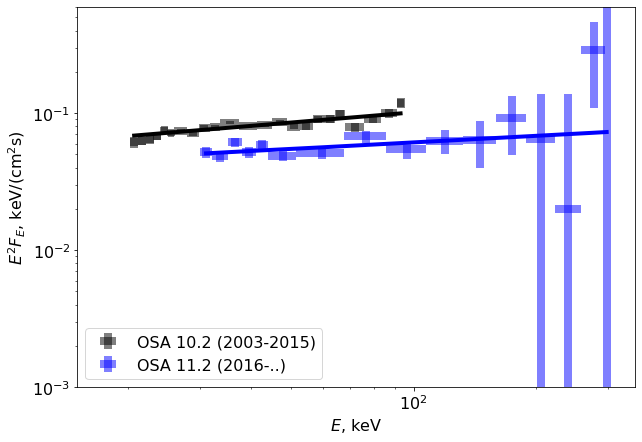

In [33]:
plt.figure(figsize=(10,7))

spectrum=np.genfromtxt(name+'_spectrum_osa10.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=0.5,label='OSA 10.2 (2003-2015)')
plt.plot(en,mo,color='black',linewidth=4)

spectrum=np.genfromtxt(name+'_spectrum_osa11.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='blue',alpha=0.5,label='OSA 11.2 (2016-..)')
plt.plot(en,mo,color='blue',linewidth=4)


plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-3,6.e-1)
plt.xlim(15,350)
plt.xlabel('$E$, keV',fontsize=16)
plt.ylabel('$E^2F_E$, keV/(cm$^2$s)',fontsize=16)
plt.legend(loc='lower left',fontsize=16)
plt.savefig(name+'_spectrum.pdf',format='pdf',dpi=100)




In [34]:
spectrum_pdf=name+'_spectrum.pdf'